In [2]:
import scipy as sc
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# transfer functions visuals

In [3]:
# Define symbols
s = sp.symbols('s')
D, H, tau = sp.symbols('D H tau')
D1, H1, tau1 = sp.symbols('D1 H1 tau1')
D2, H2, tau2 = sp.symbols('D2 H2 tau2')

# |I| = 1, K = 2
G = (-D - H*s)/(tau*s + 1) - (
    (-D1 - H1*s)/(tau1*s + 1) +
    (-D2 - H2*s)/(tau2*s + 1)
)

print("Symbolic Transfer Function G(s):")
sp.pprint(sp.simplify(G))

Symbolic Transfer Function G(s):
  D + H⋅s   D₁ + H₁⋅s   D₂ + H₂⋅s
- ─────── + ───────── + ─────────
  s⋅τ + 1   s⋅τ₁ + 1    s⋅τ₂ + 1 


Using the fact that:
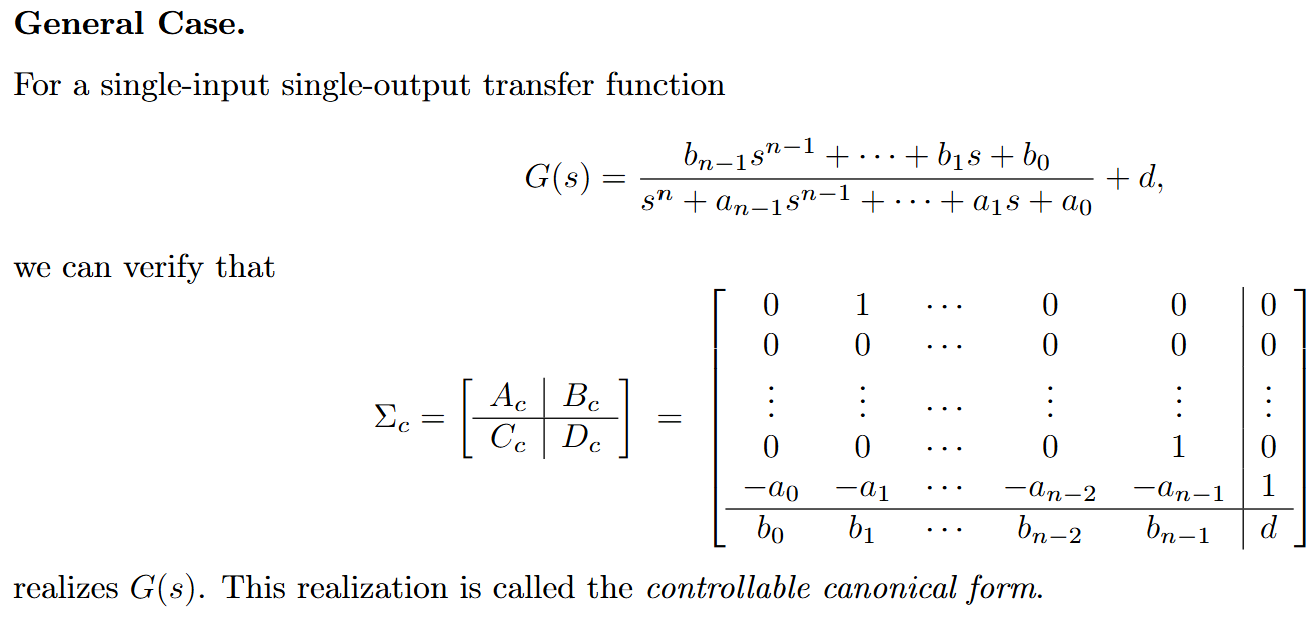

In [4]:
# --- Step 1: simplify into single rational function ---
G_simplified = sp.together(sp.simplify(G))  # forces common denominator
print("\nSimplified G(s):")
sp.pprint(G_simplified)

# --- Step 2: extract numerator and denominator ---
num, den = sp.fraction(G_simplified)

num_poly = sp.Poly(num, s)
den_poly = sp.Poly(den, s)

num_coeffs = num_poly.all_coeffs()
den_coeffs = den_poly.all_coeffs()

print("\nNumerator coefficients:", num_coeffs)
print("Denominator coefficients:", den_coeffs)

# important: devide by den_coeffs[0] always to normalize!!!

# Build controllable canonical form
n = len(den_coeffs) - 1  # system order

# Companion matrix A
A = sp.zeros(n)
for i in range(n-1):
    A[i, i+1] = 1
A[-1, :] = sp.Matrix([[-c/den_coeffs[0] for c in den_coeffs[1:]]])  # FIXED

# Input vector B
B = sp.zeros(n, 1)
B[-1, 0] = 1

# Output vector C
# Pad numerator if needed
m = len(num_coeffs)
if m < n+1:
    num_coeffs = [0]*(n+1-m) + num_coeffs
C = sp.Matrix([[c/den_coeffs[0] for c in num_coeffs[1:]]])

# Feedthrough term Dmat
Dmat = sp.Matrix([[num_coeffs[0]/den_coeffs[0]]])


Simplified G(s):
-(D + H⋅s)⋅(s⋅τ₁ + 1)⋅(s⋅τ₂ + 1) + (D₁ + H₁⋅s)⋅(s⋅τ + 1)⋅(s⋅τ₂ + 1) + (D₂ + H₂ ↪
────────────────────────────────────────────────────────────────────────────── ↪
                                   (s⋅τ + 1)⋅(s⋅τ₁ + 1)⋅(s⋅τ₂ + 1)             ↪

↪ ⋅s)⋅(s⋅τ + 1)⋅(s⋅τ₁ + 1)
↪ ────────────────────────
↪                         

Numerator coefficients: [-H*tau1*tau2 + H1*tau*tau2 + H2*tau*tau1, -D*tau1*tau2 + D1*tau*tau2 + D2*tau*tau1 - H*tau1 - H*tau2 + H1*tau + H1*tau2 + H2*tau + H2*tau1, -D*tau1 - D*tau2 + D1*tau + D1*tau2 + D2*tau + D2*tau1 - H + H1 + H2, -D + D1 + D2]
Denominator coefficients: [tau*tau1*tau2, tau*tau1 + tau*tau2 + tau1*tau2, tau + tau1 + tau2, 1]


In [5]:
from IPython.display import display

print("Controllable Canonical Form:")

print("\nA =")
display(A)   # nice LaTeX rendering

print("\nB =")
display(B)

print("\nC =")
display(C)

print("\nD =")
display(Dmat)


Controllable Canonical Form:

A =


Matrix([
[                                                 0,                                    1,                  0],
[                                                 0,                                    0,                  1],
[(-tau*tau1 - tau*tau2 - tau1*tau2)/(tau*tau1*tau2), (-tau - tau1 - tau2)/(tau*tau1*tau2), -1/(tau*tau1*tau2)]])


B =


Matrix([
[0],
[0],
[1]])


C =


Matrix([[(-D*tau1*tau2 + D1*tau*tau2 + D2*tau*tau1 - H*tau1 - H*tau2 + H1*tau + H1*tau2 + H2*tau + H2*tau1)/(tau*tau1*tau2), (-D*tau1 - D*tau2 + D1*tau + D1*tau2 + D2*tau + D2*tau1 - H + H1 + H2)/(tau*tau1*tau2), (-D + D1 + D2)/(tau*tau1*tau2)]])


D =


Matrix([[(-H*tau1*tau2 + H1*tau*tau2 + H2*tau*tau1)/(tau*tau1*tau2)]])

In [6]:
import control as ct

In [7]:
G = ct.tf([1], [2, 1], input='u1', output='y1')
G2 = ct.tf([1], [5, 1], input='u2', output='y2')
summing = ct.summing_junction(['y1', 'y2'], 'y', name='summing')
Gtot = ct.interconnect([G, G2, summing], inputs=['u1', 'u2'], outputs=['y1', 'y2', 'y'])
T = int(1e2)
t = np.arange(T) * 0.1
u1, u2 = np.ones(T), -np.ones(T)

response = ct.input_output_response(Gtot, t, [u1, u2], [1, -1])
response.outputs.shape

(3, 100)

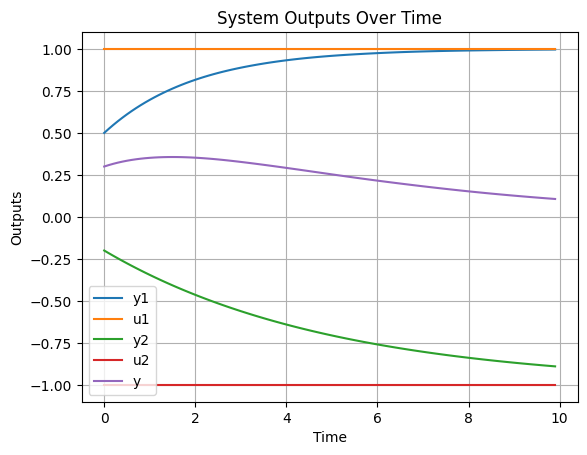

In [8]:
# plot ouput
plt.plot(response.time, response.outputs[0], label='y1')
plt.plot(response.time, response.inputs[0], label='u1')
plt.plot(response.time, response.outputs[1], label='y2')
plt.plot(response.time, response.inputs[1], label='u2')
plt.plot(response.time, response.outputs[2], label='y')
plt.xlabel('Time')
plt.ylabel('Outputs')
plt.legend()
plt.grid()
plt.title('System Outputs Over Time')
plt.show()

# opt bid experiments

In [9]:
def bid_value(bids, rhos, bid,
              return_prob=False):
    gamma = sum(rhos[b] for b in bids if b >= bid)
    if return_prob:
        return gamma
    return bid * (4 * gamma - 3)

In [10]:
def bids_to_values(bids, rhos, return_prob=False) -> np.ndarray:
    values = np.array([bid_value(bids, rhos, b, return_prob=False) for b in bids])
    if not return_prob:
        return values
    else:
        gammas = np.array([bid_value(bids, rhos, b, return_prob=True) for b in bids])
        return gammas, values

In [11]:
# from src.get_pv_wind_probs import get_prod_forecast_data

In [12]:
# df, df_forecast = get_prod_forecast_data()

In [13]:
# # get for hour 12: 30 samples from the data
# # df has datetime index
# hour = 12
# # samples should be at same datime index
# samples = 300
# bids_df = df[df.index.hour == hour].sample(n=samples, random_state=42)
# # remove nan values
# bids_df = bids_df.dropna()
# bids = bids_df.iloc[:, 0].to_numpy().flatten()
# bids_2 = bids_df.iloc[:, 1].to_numpy().flatten()
# # scale
# bids = bids * 10
# bids_2 = bids_2 * 10

In [14]:
df_wind = pd.read_csv('data/ren_ninja_data/ninja_wind_62.7739_23.7594_corrected.csv', index_col=0, skiprows=3, parse_dates=True)
df_pv = pd.read_csv('data/ren_ninja_data/ninja_pv_62.7739_23.7594_corrected.csv', index_col=0, skiprows=3, parse_dates=True)

In [15]:
df_wind.drop('local_time', axis=1, inplace=True)
df_pv.drop('local_time', axis=1, inplace=True)
df_wind.columns = ['wind_power']
df_pv.columns = ['pv_power']

In [16]:
# combine to one df
df = pd.concat([df_wind, df_pv], axis=1)

In [17]:
hour = 12
# samples should be at same datime index
samples = 300
bids_df = df[df.index.hour == hour].sample(n=samples, random_state=42)
# remove nan values
bids_df = bids_df.dropna()
bids = bids_df.iloc[:, 0].to_numpy().flatten()
bids_2 = bids_df.iloc[:, 1].to_numpy().flatten()
# scale
bids = bids * 10
bids_2 = bids_2 * 10

In [18]:
# try own simulation
samples = 10
bids = np.append(np.repeat(20, 9), 0)  # Wind
bids_2 = np.repeat(10, 10)  # PV
# add noise to bids
# bids = bids + np.random.normal(0, 1, size=bids.shape)
# bids_2 = bids_2 + np.random.normal(0, 1, size=bids_2.shape)

In [19]:
# sort bids
bids, bids_2 = np.sort(bids), np.sort(bids_2)
rhos = {b: 1/len(bids) for b in bids}  # uniform distribution
rhos_2 = {b: 1/len(bids_2) for b in bids_2}  # uniform distribution
vals = bids_to_values(bids, rhos)
vals_2 = bids_to_values(bids_2, rhos_2)
# get probabilities
gammas_1, _ = bids_to_values(bids, rhos, return_prob=True)
gammas_2, _ = bids_to_values(bids_2, rhos_2, return_prob=True)

In [20]:
# get added bids
added_bids = bids + bids_2
added_rhos = {b: 1/len(added_bids) for b in added_bids}
added_vals = bids_to_values(added_bids, added_rhos)
added_gammas, _ = bids_to_values(added_bids, added_rhos, return_prob=True)

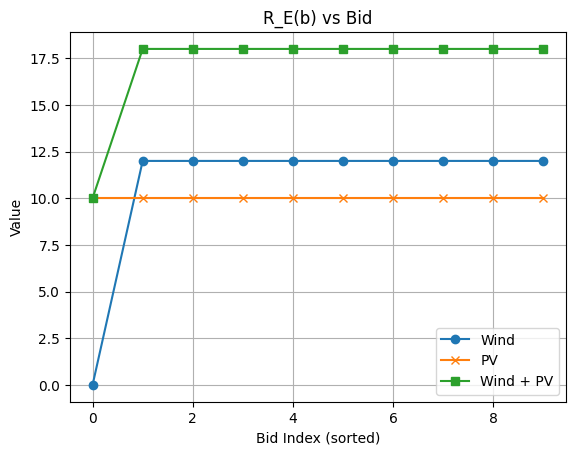

In [21]:
# visualize
# first, cut off at negative values
# DONT CUT OFF FOR NOW
# idx_where_nonneg = np.where(added_vals >= 0)[0][-1] + 2
# added_bids = added_bids[:idx_where_nonneg]
# added_vals = added_vals[:idx_where_nonneg]
# vals = vals[:idx_where_nonneg]
# vals_2 = vals_2[:idx_where_nonneg]
x_ks = np.arange(len(added_bids))

plt.plot(x_ks, vals, marker='o', label='Wind')
plt.plot(x_ks, vals_2, marker='x', label='PV')
plt.plot(x_ks, added_vals, marker='s', label='Wind + PV')
# plt.plot(x_ks, diff, marker='d', label='Difference')
plt.xlabel('Bid Index (sorted)')
plt.ylabel('Value')
plt.title('R_E(b) vs Bid')
plt.grid(True)
plt.legend()
plt.show()

In [22]:
# print idx and bid of max value
max_idx = np.argmax(added_vals)
print(f"Max value at index {max_idx}, bid: {added_bids[max_idx]:.3f}, value: {added_vals[max_idx]:.3f}")
max_idx_1 = np.argmax(vals)
print(f"Max value set 1 at index {max_idx_1}, bid: {bids[max_idx_1]:.3f}, value: {vals[max_idx_1]:.3f}")
max_idx_2 = np.argmax(vals_2)
print(f"Max value set 2 at index {max_idx_2}, bid: {bids_2[max_idx_2]:.3f}, value: {vals_2[max_idx_2]:.3f}")
print(f"Difference of Max: bid12 - (bid1 + bid2)={added_bids[max_idx] - (bids[max_idx_1] + bids_2[max_idx_2]):.6f}, value12 - (value1 + value2)={added_vals[max_idx] - (vals[max_idx_1] + vals_2[max_idx_2]):.6f}")

Max value at index 1, bid: 30.000, value: 18.000
Max value set 1 at index 1, bid: 20.000, value: 12.000
Max value set 2 at index 0, bid: 10.000, value: 10.000
Difference of Max: bid12 - (bid1 + bid2)=0.000000, value12 - (value1 + value2)=-4.000000


In [23]:
(vals[max_idx_1] + vals_2[max_idx_2])

np.float64(22.0)

In [24]:
# empirical check
import pandas as pd
df = pd.read_csv('pics/v_case_0604/expected_values_DPF.csv', index_col=0, header=[0,1,2])

In [25]:
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]
df.set_index(df.columns[0], inplace=True)
from src.game_theory_helpers import game_is_superadditive
players = [c[0] for c in df.columns if len(c)==1]

In [26]:
super_additive_couter = 0
for idx, row in df.iterrows():
    # create value function
    v = {frozenset(k): val for k, val in row.items()}
    # add empty set
    v[frozenset()] = 0
    # check super-additivity
    result = game_is_superadditive(v, players, tol=5e-4, print_warnings=True)
    if result:
        print(f"   at index {idx}")
        super_additive_couter += 1
    # else:
    #     print(f"Game not super-additive for index {idx}: {v}")
print(f"Number of super-additive games: {super_additive_couter} out of {len(df)}")

   at index 0
   at index 1
   at index 2
   at index 3
Game is not superadditive: frozenset({'PV'}), frozenset({'Wind'})
Game is not superadditive: frozenset({'PV'}), frozenset({'Wind'})
Game is not superadditive: frozenset({'PV'}), frozenset({'Wind'})
   at index 7
   at index 8
Game is not superadditive: frozenset({'PV'}), frozenset({'Wind'})
Game is not superadditive: frozenset({'PV'}), frozenset({'Wind'})
   at index 11
Game is not superadditive: frozenset({'PV'}), frozenset({'Wind'})
Game is not superadditive: frozenset({'PV'}), frozenset({'Wind'})
   at index 14
Game is not superadditive: frozenset({'PV'}), frozenset({'Wind'})
   at index 16
   at index 17
   at index 18
   at index 19
   at index 20
   at index 21
   at index 22
   at index 23
   at index 24
Number of super-additive games: 17 out of 25


In [27]:
# save the bids and values to csv
import pandas as pd

df_bids_values = pd.DataFrame({
    'bids_1': bids,
    'values_1': vals,
    'gammas_1': gammas_1,
    'bids_2': bids_2,
    'values_2': vals_2,
    'gammas_2': gammas_2,
    'added_bids': added_bids,
    'added_values': added_vals,
    'added_gammas': added_gammas
})
df_bids_values.to_csv("data/bids/bids_values.csv", index=False)

## empircal check \#2
check if bids align with theory

In [28]:
df = pd.read_csv('pics/v_case_0604/bids_DPF_FFR-FCR.csv', header=0)
# df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]
# df.set_index(df.columns[0], inplace=True)
# players = [c[0] for c in df.columns if len(c)==1]
K_scenarios = 20
df

,Unnamed: 0,Unnamed: 1,"('PV',)","('Wind',)","('BESS',)","('PV', 'Wind')","('PV', 'BESS')","('Wind', 'BESS')","('PV', 'Wind', 'BESS')"
0,2025-04-06 00:00:00,0,-0.3,1.83534,-0.3,1.83757,-0.3,4.06751,4.07246
1,2025-04-06 00:00:00,1,-0.3,1.12133,-0.3,1.12133,-0.3,3.50795,3.50795
2,2025-04-06 00:00:00,2,-0.3,1.34024,-0.3,1.34024,-0.3,3.70376,3.70376
3,2025-04-06 00:00:00,3,-0.3,2.19507,-0.3,2.19507,-0.3,4.46429,4.46429
4,2025-04-06 00:00:00,4,-0.3,0.94432,-0.3,0.94432,-0.3,2.95420,2.95420
...,...,...,...,...,...,...,...,...,...
495,2025-04-07 00:00:00,15,-0.3,1.53613,-0.3,1.53658,-0.3,3.87146,3.87259
496,2025-04-07 00:00:00,16,-0.3,2.05029,-0.3,2.05029,-0.3,4.29452,4.29452
497,2025-04-07 00:00:00,17,-0.3,2.06448,-0.3,2.06448,-0.3,4.32426,4.32426
498,2025-04-07 00:00:00,18,-0.3,1.94149,-0.3,1.94239,-0.3,4.18471,4.18663


# continous optimal bid 

In [29]:
import numpy as np
from scipy.stats import beta, gaussian_kde
from scipy.optimize import brentq
import matplotlib.pyplot as plt

--- Method 1: Parametric (Beta a=2.0, b=5.0) ---
Optimal Contract C*: 0.0875 (8.75% of nameplate capacity)

--- Method 2: Empirical (KDE from data) ---
Optimal Contract C*: 0.0909 (9.09% of nameplate capacity)


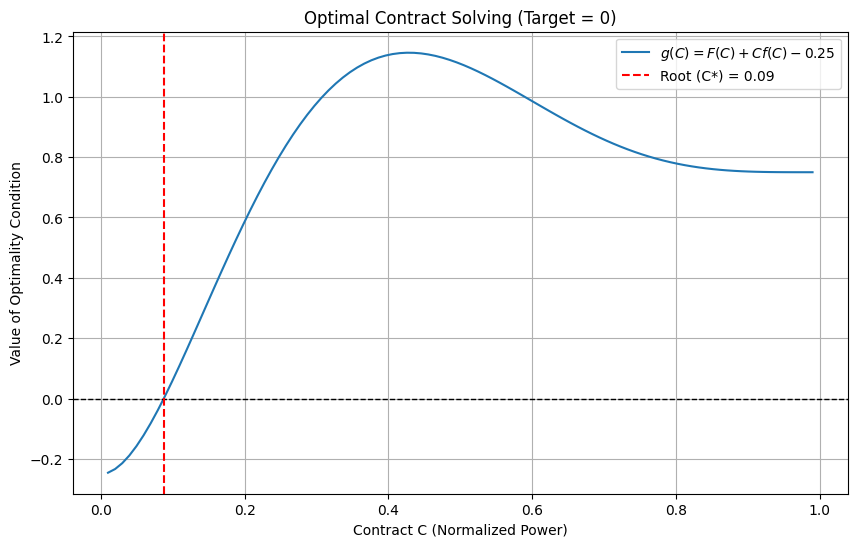

In [30]:
def solve_optimal_contract(pdf_func, cdf_func):
    """
    Finds C* such that F(C) + C*f(C) = 0.25 using the Brent root-finding method.
    """
    
    # Define the target equation: g(C) = F(C) + C*f(C) - 0.25
    def target_equation(C):
        # Clamp C to slightly inside [0,1] to avoid math errors at boundaries
        C = max(1e-6, min(1.0 - 1e-6, C))
        return cdf_func(C) + (C * pdf_func(C)) - 0.25

    # We look for a root between 0 and 1 (normalized capacity)
    try:
        # brentq is a robust root-finding method for bounded intervals
        optimal_C = brentq(target_equation, 0, 1)
        return optimal_C
    except ValueError:
        return None # No solution found in range

# ==========================================
# METHOD 1: Parametric (Beta Distribution)
# ==========================================
# Wind power is often modeled as Beta(a, b) because it is bounded [0, 1].
# You can fit these parameters to your historical data.

# Example parameters (a=2, b=5 implies skewed towards lower wind, typical for some sites)
a_param, b_param = 2.0, 5.0 
wind_dist = beta(a_param, b_param)

C_star_beta = solve_optimal_contract(wind_dist.pdf, wind_dist.cdf)

print(f"--- Method 1: Parametric (Beta a={a_param}, b={b_param}) ---")
print(f"Optimal Contract C*: {C_star_beta:.4f} ({C_star_beta*100:.2f}% of nameplate capacity)")


# ==========================================
# METHOD 2: Empirical (Raw Data / KDE)
# ==========================================
# If you have raw time-series data like the BPA data in the paper 

# 1. Generate fake sample data (replace this with your actual CSV data)
np.random.seed(42)
raw_wind_data = np.random.beta(a_param, b_param, 1000)

# 2. Create a Kernel Density Estimate (smooths the data)
kde = gaussian_kde(raw_wind_data)

# 3. Define wrappers for PDF and CDF
def kde_pdf(x):
    return kde.evaluate(x)[0]

def kde_cdf(x):
    # Gaussian_kde integrates from -inf, but we know wind >= 0
    return kde.integrate_box_1d(0, x)

C_star_empirical = solve_optimal_contract(kde_pdf, kde_cdf)

print(f"\n--- Method 2: Empirical (KDE from data) ---")
print(f"Optimal Contract C*: {C_star_empirical:.4f} ({C_star_empirical*100:.2f}% of nameplate capacity)")

# ==========================================
# VISUALIZATION
# ==========================================
# Let's plot the function to visualize where it crosses 0
x_vals = np.linspace(0.01, 0.99, 100)
y_vals = [wind_dist.cdf(x) + x*wind_dist.pdf(x) - 0.25 for x in x_vals]

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label=r'$g(C) = F(C) + C f(C) - 0.25$')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(C_star_beta, color='red', linestyle='--', label=f'Root (C*) = {C_star_beta:.2f}')
plt.title(f'Optimal Contract Solving (Target = 0)')
plt.xlabel('Contract C (Normalized Power)')
plt.ylabel('Value of Optimality Condition')
plt.legend()
plt.grid(True)
plt.show()

## quick plots

In [31]:
# plot with 0 curve

from src.get_required_services import get_ffr_fcr, get_ffr, get_fcr

In [32]:
#plot graph of get_ffr_fcr
ts_fcr_max, input_ffrfcr_max, curve_ffrfcr_min = get_ffr()

In [33]:
plt.rcParams['text.usetex'] = False

Text(0, 0.5, 'Required FFR + FCR Capacity (MW)')

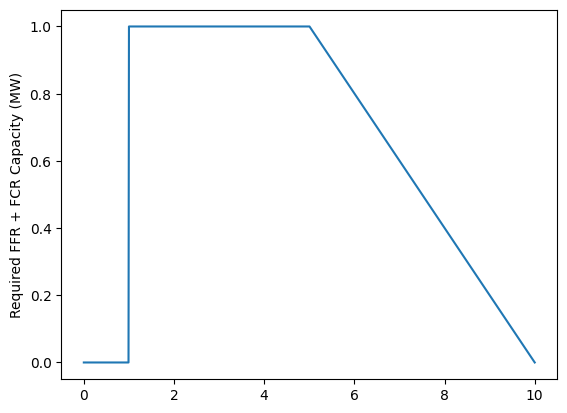

In [34]:
plt.plot(ts_fcr_max, curve_ffrfcr_min, label='FFR Requirement Curve')
plt.ylabel('Required FFR + FCR Capacity (MW)')

In [35]:
import matplotlib.pyplot as plt
import numpy as np

In [36]:
BIG_FSIZE = 44
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : BIG_FSIZE}

plt.rc('font', **font)

## figure for service requirement

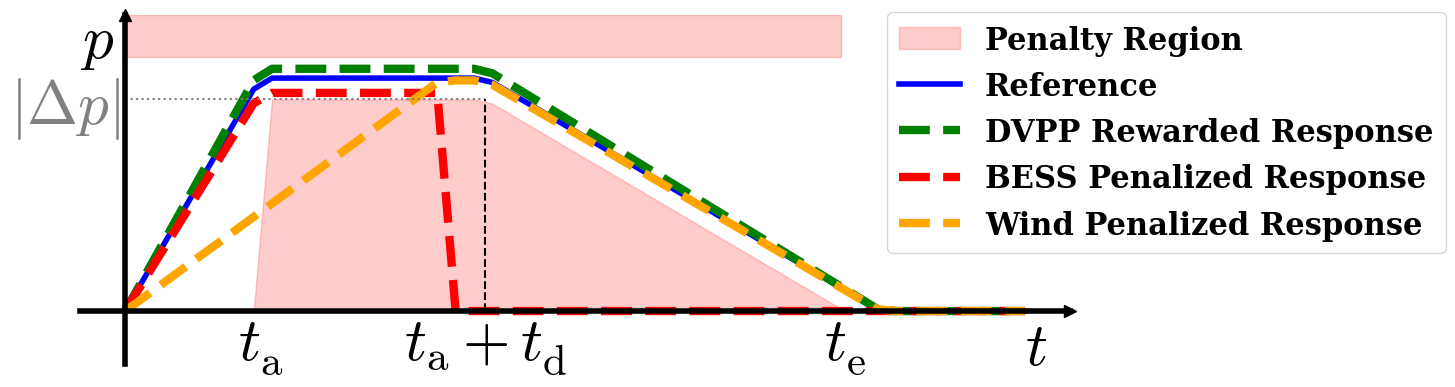

In [49]:
# --- CONFIGURATION TO FIX YOUR ERROR ---
# This forces matplotlib to use its built-in engine, not external LaTeX
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm' 
plt.rcParams['axes.axisbelow'] = True

# plt.rcParams['font.family'] = 'serif'
# ---------------------------------------

# 1. Setup Data
t_i = 1.5   
t_a = 4.0
t_e = 8.0
dt_e = t_e * 1.05
p_max = 2.0 

x = np.linspace(0, 10, 50)
y = np.piecewise(x, 
    [x < t_i, (x >= t_i) & (x <= t_a), (x > t_a) & (x <= t_e), x > t_e],
    [0, p_max, lambda x: p_max * (t_e - x) / (t_e - t_a), 0]
 )
p_ref = p_max * 1.1
y_ref = np.piecewise(x, 
    [x < t_i, (x >= t_i) & (x <= t_a), (x > t_a) & (x <= dt_e), x > dt_e],
    [lambda x: x * p_ref / t_i, p_ref, lambda x: p_ref * (dt_e - x) / (dt_e - t_a), 0]
 )
y_ref_120 = np.piecewise(x, 
                       [(x < t_e), x >= t_e],
                       [p_max * 1.2, 0]
)
topline = np.piecewise(x, 
                       [(x < t_e), x >= t_e],
                       [p_max * 1.4, 0]
)

# Example curves - one good, one bad
y_good_fac = 1.04
y_good = np.piecewise(x,
    [x < t_i, (x >= t_i) & (x <= t_a), (x > t_a) & (x <= dt_e), x > dt_e],
    [lambda x: x * p_ref * y_good_fac / t_i, p_ref * y_good_fac, lambda x: p_ref * y_good_fac * (dt_e - x) / (dt_e - t_a), 0]
)

delta_t = 2

y_bad_factor = 1.03
# y_bad = np.piecewise(x,
#     [x < t_i, (x >= t_i) & (x <= t_a), (x > t_a) & (x <= dt_e), x > dt_e],
#     [lambda x: x * p_max * y_bad_factor / t_i, p_max * y_bad_factor, lambda x: p_max * y_bad_factor * (dt_e - x) / (dt_e - t_a), 0]
# )
y_bad = np.piecewise(x,
    [x < t_i, (x >= t_i) & (x <= t_i + delta_t), x > t_i + delta_t],
    [lambda x: x * p_max * y_bad_factor / t_i, p_max * y_bad_factor, 0]
)
# make y_bad zero at t_i + delta_t

# add another bad curve that is too slow
y_slow_factor = .99
y_bad_slow = np.piecewise(x,
    [x < t_i + delta_t, (x >= t_i + delta_t) & (x <= t_a), (x > t_a) & (x <= dt_e), x > dt_e],
    [lambda x: x * p_ref * y_slow_factor / (t_i + delta_t), p_ref * y_slow_factor, lambda x: p_ref * y_slow_factor * (dt_e - x) / (dt_e - t_a), 0]
)

# add some noise to y_good and y_bad, but smooth overall trend
# noise_level = 0.01
# noise_level_bad = 0.02
# y_good += noise_level * p_max * np.random.randn(*y_good.shape)
# y_bad += noise_level_bad * p_max * np.random.randn(*y_bad.shape)
# y_bad_slow += noise_level_bad * p_max * np.random.randn(*y_bad_slow.shape)


# 2. Plot Setup
fig, ax = plt.subplots(figsize=(12, 5))

# 3. Plot the Main Curve
# ax.plot(x, y, color='#999999', linewidth=6, solid_capstyle='round',
#         label='Min. Requirement')
# Fill area under requirement
ax.fill_between(x, 0, y, color='red', alpha=0.2, label='Penalty Region')

# Shade requirement above 1.2 * y_ref
mask_above = (x >= 0) & (x <= t_e)
ax.fill_between(x, y_ref_120, topline, color='red', alpha=0.2, where=mask_above)

# Reference curve
ax.plot(x, y_ref, color='b', linewidth=4, label='Reference')

# Example curves - good and bad
ax.plot(x, y_good, color='g', linewidth=6, linestyle='--', label='DVPP Rewarded Response')
ax.plot(x, y_bad, color='r', linewidth=6, linestyle='--', label='BESS Penalized Response')
ax.plot(x, y_bad_slow, color='orange', linewidth=6, linestyle='--', label='Wind Penalized Response')

# 4. Add Guidelines
ax.hlines(y=p_max, xmin=0, xmax=t_a, colors='gray', linestyles=':', linewidth=1.5)
ax.vlines(x=t_a, ymin=0, ymax=p_max, colors='black', linestyles='--', linewidth=1.5)

# 5. Customize Axes (Arrow Style)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Add arrowheads manually at the ends of the axes
ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False, markersize=8)
ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False, markersize=8)

# 6. Labels using Internal Math Text (No external LaTeX needed)
ax.set_xticks([t_i, t_a, t_e])
ax.set_xticklabels([r'$t_\mathrm{a}^\mathrm{}$', r'$t_\mathrm{a}+t_\mathrm{d}^\mathrm{}$', r'$t_\mathrm{e}^\mathrm{}$'], fontsize=BIG_FSIZE)
    
ax.set_yticks([p_max])
ax.set_yticklabels([r'$|\Delta p|$'], fontsize=BIG_FSIZE, color='gray')

# 7. Axis Titles
ax.text(max(x), -0.5, '$t$', fontsize=BIG_FSIZE, style='italic')
ax.text(-.5, p_max * 1.2, r'$p$', fontsize=BIG_FSIZE)

ax.set_xlim(-0.5, 10.5)
ax.set_ylim(-0.5, p_max * 1.4)
ax.tick_params(axis='both', which='both', length=0) 

# axis linewidth
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)

plt.tight_layout()
plt.legend(fontsize=BIG_FSIZE/2, loc='upper left', bbox_to_anchor=(.8, 1.05))

plt.savefig('pics/service_example.png', dpi=600, bbox_inches='tight')
plt.show()

In [38]:
import matplotlib as mpl

Color 0: (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)
Color 1: (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)
Color 2: (0.4588235294117647, 0.4392156862745098, 0.7019607843137254)
Color 3: (0.9058823529411765, 0.1607843137254902, 0.5411764705882353)
Color 4: (0.4, 0.6509803921568628, 0.11764705882352941)
Color 5: (0.9019607843137255, 0.6705882352941176, 0.00784313725490196)
Color 6: (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)
Color 7: (0.4, 0.4, 0.4)


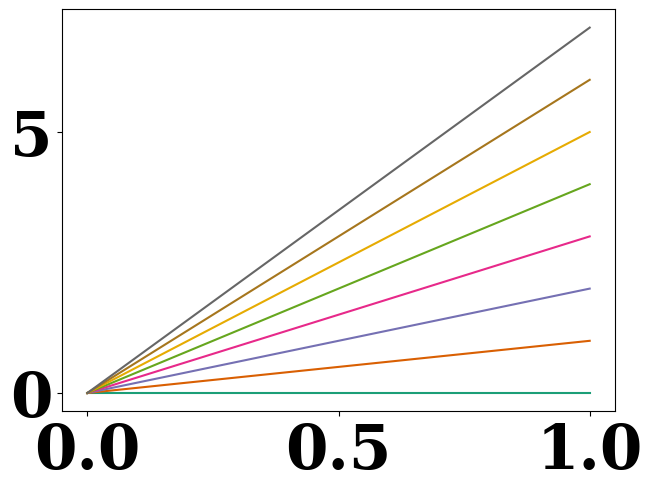

In [39]:
colors = mpl.colormaps['Dark2'].colors

fig, ax = plt.subplots(layout='constrained')

for i, color in enumerate(colors):
    ax.plot([0, i], color=color)
    print(f"Color {i}: {color}")

plt.show()

# frequency data visualization

In [40]:
import glob
import os

In [41]:
month = '2025-04'

glob_pattern = f'data/frequency_data/{month}/{month}/*.csv'
file_list = glob.glob(glob_pattern)
print(f"Found {len(file_list)} files matching pattern.")

Found 30 files matching pattern.


In [42]:
ffr_1 = 49.7
ffr_2 = 49.6
ffr_3 = 49.5
fcrd_d_1 = 49.9
fcrd_u_1 = 50.1

In [43]:
count_below_ffr1 = 0
count_below_ffr2 = 0
count_below_ffr3 = 0
count_below_fcrd_d1 = 0
count_above_fcrd_u1 = 0

In [44]:
idx_start = 5
# start_file, end_file = file_list[idx_start], file_list[idx_start + 6]
# for f in file_list[idx_start:idx_start + 7]:
for f in file_list:
    df = pd.read_csv(f, index_col=0, parse_dates=True)
    df.columns = ['frequency']
    # make one second average
    # df_resampled = df.resample('1s').mean()
    df_resampled = df
    # print(df_resampled.head())
    # count how often frequency goes below frequency thresholds
    count_below_ffr1 += (df_resampled['frequency'] < ffr_1).sum()
    
    # count how often frequency goes above ffr_2
    count_below_ffr2 += (df_resampled['frequency'] < ffr_2).sum()
    
    count_below_ffr3 += (df_resampled['frequency'] < ffr_3).sum()
    
    count_below_fcrd_d1 += (df_resampled['frequency'] < fcrd_d_1).sum()
    
    count_above_fcrd_u1 += (df_resampled['frequency'] > fcrd_u_1).sum()
    
print(f"Count below FFR_1 ({ffr_1} Hz): {count_below_ffr1/10:.2f} seconds")
print(f"Count below FFR_2 ({ffr_2} Hz): {count_below_ffr2/10:.2f} seconds")
print(f"Count below FFR_3 ({ffr_3} Hz): {count_below_ffr3/10:.2f} seconds")
print(f"Count below FCRD_D_1 ({fcrd_d_1} Hz): {count_below_fcrd_d1/600:.2f} minutes")
print(f"Count above FCRD_U_1 ({fcrd_u_1} Hz): {count_above_fcrd_u1/600:.2f} minutes")

Count below FFR_1 (49.7 Hz): 0.00 seconds
Count below FFR_2 (49.6 Hz): 0.00 seconds
Count below FFR_3 (49.5 Hz): 0.00 seconds
Count below FCRD_D_1 (49.9 Hz): 216.33 minutes
Count above FCRD_U_1 (50.1 Hz): 313.56 minutes


In [45]:
# load for entire year
df_year = pd.read_csv('data/frequency_data/frequencies_24_25.csv', sep=';', index_col=0, parse_dates=True)
df_year.drop('endTime', axis=1, inplace=True)
df_year.columns = ['frequency']

FileNotFoundError: [Errno 2] No such file or directory: 'data/frequency_data/frequencies_24_25.csv'

In [ ]:
# do same test as above for entire year data
count_below_ffr1 = (df_year['frequency'] < fcrd_d_1).sum()
print(f"Yearly Count below FCRD_D_1 ({fcrd_d_1} Hz): {count_below_ffr1} - 3minutes")
count_above_fcrd_u1 = (df_year['frequency'] > fcrd_u_1).sum()
print(f"Yearly Count above FCRD_U_1 ({fcrd_u_1} Hz): {count_above_fcrd_u1} - 3minutes")
count_below_ffr1 = (df_year['frequency'] < ffr_1).sum()
print(f"Yearly Count below FFR_1 ({ffr_1} Hz): {count_below_ffr1} - 3minutes")
count_below_ffr2 = (df_year['frequency'] < ffr_2).sum()
print(f"Yearly Count below FFR_2 ({ffr_2} Hz): {count_below_ffr2} - 3minutes")
count_below_ffr3 = (df_year['frequency'] < ffr_3).sum()
print(f"Yearly Count below FFR_3 ({ffr_3} Hz): {count_below_ffr3} - 3minutes")

Yearly Count below FCRD_D_1 (49.9 Hz): 712 - 3minutes
Yearly Count above FCRD_U_1 (50.1 Hz): 929 - 3minutes
Yearly Count below FFR_1 (49.7 Hz): 0 - 3minutes
Yearly Count below FFR_2 (49.6 Hz): 0 - 3minutes
Yearly Count below FFR_3 (49.5 Hz): 0 - 3minutes
